In [1]:
# Import dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Importing Dependencies for DB connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
import config
import psycopg2

In [2]:
# Establish a connection to the database
conn = psycopg2.connect(
    host = config.config['host'],
    port = config.config['port'], 
    dbname = config.config['dbname'], 
    user = config.config['user'], 
    password = config.config['password'])

print("Postgres Connected")

Postgres Connected


In [216]:
# Import Data from AWS database
df= pd.read_sql_query('SELECT ref_date,total_vacancies FROM "canada_vacancies"', con=conn)
df

,ref_date,total_vacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0
5,2016-07-01,404860.0
6,2016-10-01,381010.0
7,2017-01-01,387080.0
8,2017-04-01,459685.0
9,2017-07-01,467395.0


In [217]:
# remove Q3 2020- Q22021
df = df[0:20]
df

,ref_date,total_vacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0
5,2016-07-01,404860.0
6,2016-10-01,381010.0
7,2017-01-01,387080.0
8,2017-04-01,459685.0
9,2017-07-01,467395.0


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         20 non-null     object 
 1   total_vacancies  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 448.0+ bytes


In [219]:
#  convert the REF_DATE column into a datetime object
df['ref_date'] = pd.to_datetime(df['ref_date'], format='%Y-%m')
df.head()

,ref_date,total_vacancies
0,2015-04-01,451925.0
1,2015-07-01,407865.0
2,2015-10-01,358755.0
3,2016-01-01,330215.0
4,2016-04-01,391190.0


In [220]:
df.set_index('ref_date', inplace=True)
df.shape

(20, 1)

## Time series Analysis 

In [221]:
#visualize the time series data

(array([16436., 16801., 17167., 17532., 17897., 18262.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

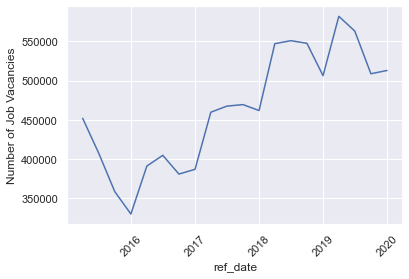

In [222]:
sns.lineplot(data= df, x='ref_date', y= 'total_vacancies')
plt.ylabel('Number of Job Vacancies')
plt.xticks(rotation=45)

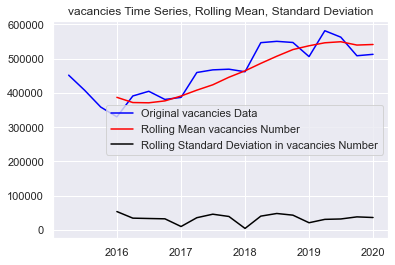

In [223]:
'''check for stationary
A stationary time series will not have any trends or seasonal patterns
We will use the Dickey Fuller test to check for stationarity in our data '''

rolling_mean = df.rolling(4).mean()
rolling_std = df.rolling(4).std()

#First, let’s make a Matplotlib plot of our time series
plt.plot(df, color="blue",label="Original vacancies Data")
# then the rolling mean
plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
#And finally, the rolling standard deviation:
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
#Let’s then add a title:
plt.title("vacancies Time Series, Rolling Mean, Standard Deviation")
#And a legend:
plt.legend(loc="best")

In [224]:
#We will use the Dickey Fuller test to check for stationarity in our data
from statsmodels.tsa.stattools import adfuller
df_test=df.iloc[:,0].values
adft = adfuller(df_test,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.354507              Test Statistics
1   0.603882                      p-value
2   7.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)


our data is not stationary as p value is higher than 0.05

In [225]:
# Checking for autocorrelation in time series data
# This is a measure of how correlated time series data is at a given point in time with past values
autocorrelation_lag1 = df['total_vacancies'].autocorr(lag=1)
print("One Quarter Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = df['total_vacancies'].autocorr(lag=2)
print("Two Quaretrs Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = df['total_vacancies'].autocorr(lag=3)
print("Three Quaretrs Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = df['total_vacancies'].autocorr(lag=4)
print("Four Quaretrs Lag: ", autocorrelation_lag4)

One Quarter Lag:  0.8417507442893581
Two Quaretrs Lag:  0.696557251422323
Three Quaretrs Lag:  0.6788911778498717
Four Quaretrs Lag:  0.7749030868093133


the data is autocorrelated

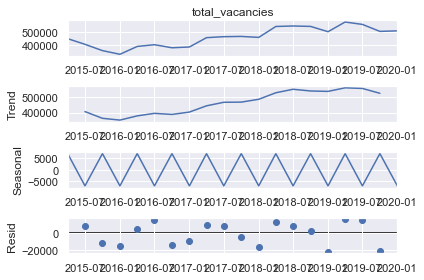

In [226]:
#Check for Trend decomposition is another useful way to visualize the trends in time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['total_vacancies'],model='additive', period=2)
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of vacancies and the seasonality patterns in the rise and fall in values each year.

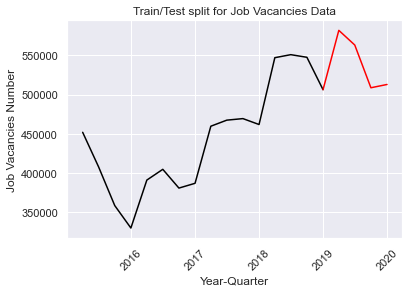

In [227]:
# Forescasting
df['ref_date']=df.index
train = df[df['ref_date'] < "2019-04-01"]
train['train'] = train['total_vacancies']
del train['ref_date']
del train['total_vacancies']

test = df[df['ref_date'] >= "2019-04-01"]
del test['ref_date']
test['test'] = test['total_vacancies']
del test['total_vacancies']

plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
sns.set()
plt.show()

In [228]:
pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test])

,test
ref_date,
2019-01-01,506140.0
2019-04-01,581595.0
2019-07-01,562910.0
2019-10-01,508590.0
2020-01-01,512760.0


## SARIMA

source: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [229]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [230]:
# Dataset
data = df
data.index = data.ref_date
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
mod = sm.tsa.statespace.SARIMAX(train, trend='t', order=(1,0,1),seasonal_order=(1, 1, 1, 2))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             train   No. Observations:                   16
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 2)   Log Likelihood                -173.872
Date:                           Mon, 22 Nov 2021   AIC                            359.743
Time:                                   14:20:59   BIC                            363.578
Sample:                               04-01-2015   HQIC                           359.388
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -977.4230      0.000  -3.24e+06      0.000    -977.424    -977.422
ar.L1         -0.6867      0.079     -8.736

In [231]:
# forecast values for test data
forecast = res.predict(test.index[0],test.index[-1], dynamic=True)
forecast = pd.DataFrame(forecast.values,index = test.index,columns=['predicted_vacancies'])
forecast.head()

,predicted_vacancies
ref_date,
2019-04-01,587459.583560
2019-07-01,550055.158540
2019-10-01,535893.292847
2020-01-01,495427.615778


In [232]:
# create dataframe for results
output = test.merge(forecast, how='inner', left_index=True, right_index=True)
output.head()

,test,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587459.583560
2019-07-01,562910.0,550055.158540
2019-10-01,508590.0,535893.292847
2020-01-01,512760.0,495427.615778


In [233]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(output.test,output.predicted_vacancies, squared=False)
rms

17645.974274639873

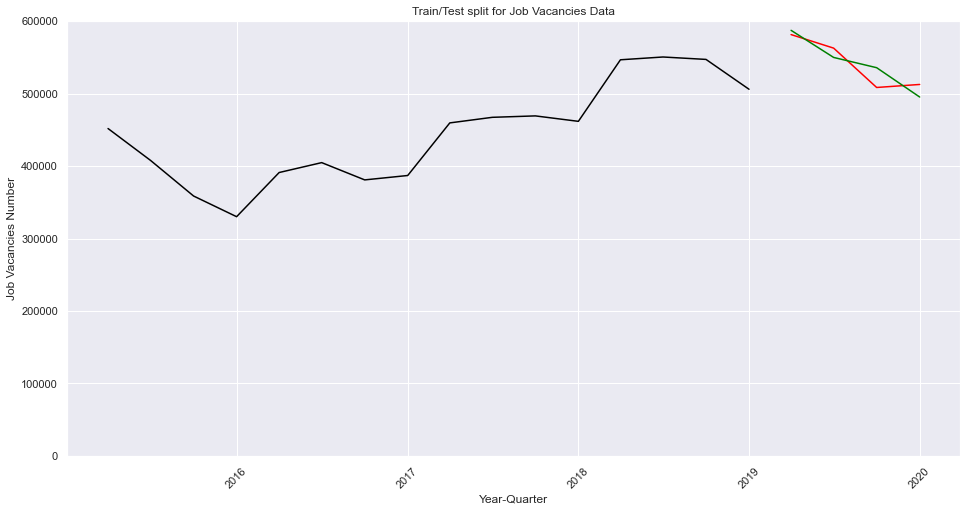

In [234]:
#visualize results
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(forecast['predicted_vacancies'],color= 'green')
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
sns.set()
plt.show()

In [235]:
# check model accuaracy with actual values from statCan
Actual=[560215,553480,731905]
predict_quarters=['2020-10-01','2021-01-01','2021-04-01']

forecast_data=[]
counter=0
for i in predict_quarters:
    forecast_test = res.predict(i)
    forecast_data.append(forecast_test)
    counter +=1
    
forecast_data

[2020-10-01    522739.55267
 Freq: QS-OCT, dtype: float64,
 2021-01-01    481984.410342
 Freq: QS-OCT, dtype: float64,
 2021-04-01    561036.264467
 Freq: QS-OCT, dtype: float64]

In [236]:
forecast_data[2].index # list of dataframes

DatetimeIndex(['2021-04-01'], dtype='datetime64[ns]', freq='QS-OCT')

In [237]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_data]

[522739, 481984, 561036]

In [238]:
# create results dataframe
forecast_df= pd.DataFrame({'Predicted Value':[int(f.values[0]) for f in forecast_data], 'Actual Value': Actual}, index=predict_quarters)
forecast_df.head()

,Predicted Value,Actual Value
2020-10-01,522739,560215
2021-01-01,481984,553480
2021-04-01,561036,731905


In [3]:
# Function to apply timeseries model on province level
def province_vac (province):
    import warnings
    warnings.filterwarnings("ignore")
    
    # Import Data from AWS database
    df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
    #  convert the REF_DATE column into a datetime object
    df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')
    #select province data 
    prov_vac= df_prov.loc[df_prov['geo']== str(province),:] 
    # drop all unnecessary columns
    prov_vac = prov_vac.loc[:,['ref_date','total_vacancies']]
    # aggregate total vacancies per quarter
    prov_vac= prov_vac.groupby(prov_vac['ref_date']).sum()
    #remove Q32020 onwards
    prov_vac= prov_vac.loc['2015-04-01':'2020-01-01']
    # rename columns
    prov_vac.rename(columns={'total_vacancies':f'{province}_total_vacancies'}, inplace=True)
    #visualize the time series data
    sns.lineplot(data= prov_vac, x='ref_date', y= f'{province}_total_vacancies')
    plt.ylabel('Number of Job Vacancies')
    plt.xticks(rotation=45)
    
    #check for stationary using the Dickey Fuller test to check for stationarity in our data
    rolling_mean = prov_vac.rolling(4).mean()
    rolling_std = prov_vac.rolling(4).std()
    #First, make a Matplotlib plot of our time series
    plt.plot(prov_vac, color="blue",label="Original vacancies Data")
    # then the rolling mean
    plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
    #And finally, the rolling standard deviation:
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
    #add a title:
    plt.title(f'{province} vacancies Time Series, Rolling Mean, Standard Deviation')
    #And a legend:
    plt.legend(loc="best")
    #use the Dickey Fuller test to check for stationarity in our data
    from statsmodels.tsa.stattools import adfuller
    prov_vac_test=prov_vac.iloc[:,0].values
    adft_prov = adfuller(prov_vac_test,autolag="AIC")
    output_prov_df = pd.DataFrame({"Values":[adft_prov[0],adft_prov[1],adft_prov[2],adft_prov[3], adft_prov[4]['1%'], adft_prov[4]['5%'], adft_prov[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print('Stationary Test Results')
    print(output_prov_df)
    
    # Checking for autocorrelation in time series data
    print('Autocorrelation Results')
    autocorrelation_lag1_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=1)
    print("One Quarter Lag: ", autocorrelation_lag1_prov)
    autocorrelation_lag2_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=2)
    print("Two Quaretrs Lag: ", autocorrelation_lag2_prov)
    autocorrelation_lag3_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=3)
    print("Three Quaretrs Lag: ", autocorrelation_lag3_prov)
    autocorrelation_lag4_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=4)
    print("Four Quaretrs Lag: ", autocorrelation_lag4_prov)
    
    #Check for Trend decomposition to visualize the trends in time series data
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose_prov = seasonal_decompose(prov_vac[f'{province}_total_vacancies'],model='additive', period=2)
    decompose_prov.plot()
    print('Trend Decomposition Visualization')
    plt.show()
    
    # Forescasting
    prov_vac['ref_date']=prov_vac.index
    train_prov = prov_vac[prov_vac['ref_date'] < "2019-04-01"]
    train_prov[f'train_{province}'] = train_prov[f'{province}_total_vacancies']
    del train_prov['ref_date']
    del train_prov[f'{province}_total_vacancies']

    test_prov = prov_vac[prov_vac['ref_date'] >= "2019-04-01"]
    del test_prov['ref_date']
    test_prov[f'test_{province}'] = test_prov[f'{province}_total_vacancies']
    del test_prov[f'{province}_total_vacancies']

    # Register converters to avoid warnings
    pd.plotting.register_matplotlib_converters()
    plt.rc("figure", figsize=(16,8))
    plt.rc("font", size=14)
    
    # Dataset
    data_prov = prov_vac
    data_prov.index = data_prov.ref_date
    # Set the frequency
    data_prov.index.freq="QS-OCT"

    # Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
    mod_prov = sm.tsa.statespace.SARIMAX(train_prov, trend='t', order=(0,1,0),seasonal_order=(1, 1, 1, 2))
    res_prov = mod_prov.fit(disp=False)
    print(res_prov.summary())
    
    # produce forecast results
    forecast_prov = res_prov.predict(test_prov.index[0],test_prov.index[-1], dynamic=True)
    forecast_prov = pd.DataFrame(forecast_prov.values,index = test_prov.index,columns=[f'Prediction_{province}'])
    output_prov = test_prov.merge(forecast_prov, how='inner', left_index=True, right_index=True)
    print('Forecast Results')
    
    
    #plot results
    plt.plot(train_prov, color = "black")
    plt.plot(test_prov, color = "red")
    plt.plot(forecast_prov[f'Prediction_{province}'],color= 'green')
    plt.title(f"Train/Test/Forecast split for {province} Job Vacancies Data")
    plt.ylabel("Job Vacancies Number")
    plt.xlabel('Year-Quarter')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    sns.set()
    plt.show()
    
    from sklearn.metrics import mean_squared_error

    rms_prov = mean_squared_error(output_prov[f'test_{province}'],output_prov[f'Prediction_{province}'], squared=False)
                                  
    print(f'RMSE is {rms_prov}')
    return output_prov
    
  

In [4]:
# produce all provinces prediction test results
provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

output_provencies= province_vac("Ontario")

for prov in provinces[1:13]:
   output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          
    
#output_provencies
print(output_provencies)

DatabaseError: Execution failed on sql 'SELECT * FROM "machinelearning"': relation "machinelearning" does not exist
LINE 1: SELECT * FROM "machinelearning"
                      ^


In [212]:
output_provencies

,test_Ontario,Prediction_Ontario,test_Quebec,Prediction_Quebec,test_British Columbia,Prediction_British Columbia,test_Alberta,Prediction_Alberta,test_Manitoba,Prediction_Manitoba,...,test_Newfoundland and Labrador,Prediction_Newfoundland and Labrador,test_Prince Edward Island,Prediction_Prince Edward Island,test_Yukon,Prediction_Yukon,test_Nunavut,Prediction_Nunavut,test_Northwest Territories,Prediction_Northwest Territories
ref_date,,,,,,,,,,,,,,,,,,,,,
2019-04-01,425185.0,423097.545767,279525.0,251590.383038,215305.0,215614.135397,118610.0,120331.121390,30220.0,33066.783650,...,8845.0,8967.058152,3745.0,4835.753881,1375.0,918.448640,730.0,932.025457,940.0,935.386965
2019-07-01,411615.0,377035.151522,273985.0,241258.658593,205430.0,212624.558826,105395.0,120199.606448,31770.0,30720.681398,...,9190.0,7607.772870,3660.0,5287.607798,1645.0,187.772215,610.0,1047.409177,1205.0,1033.551776
2019-10-01,381370.0,388306.575500,252400.0,232777.601386,179265.0,194126.963564,90380.0,126172.511634,30235.0,32666.487098,...,9095.0,8494.396604,2610.0,4477.614538,1130.0,-159.765714,455.0,1139.312125,720.0,1035.695235
2020-01-01,373185.0,328689.747536,255615.0,219086.604628,185270.0,180701.151573,96340.0,130518.910631,33265.0,31725.886526,...,8200.0,6902.500818,2125.0,3942.540727,1200.0,-933.565548,635.0,1387.310841,425.0,1143.825700


In [1]:
# close connection to DB
conn.close()

NameError: name 'conn' is not defined